# Finding Steady State Quarantine Requirements

In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
module_path

'/Users/stevewangen/projects/COVID/uw_reopening'

In [2]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [3]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    list_dfs = list()
    for sim_group in sim.sims:
        list_dfs.append(sim_group.sim_df)
    return list_dfs

def run_multiple_trajectories(sim, T, n):
    sim_results = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        sim_results.append(result)
    return sim_results

In [4]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    sim_results = run_multiple_trajectories(sim, T, n)
    return tests_per_day, sim_results

In [5]:
policy = [2/7,2/7,1/7,2/7,2/7,1/7,1/30,0]

In [78]:
base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]

ug_high_tests_per_day = ug_dorm_params['population_size'] * policy[0]

student_tests_per_day = 0
student_tests_per_day += ug_dorm_params['population_size'] * policy[0]
student_tests_per_day += ug_off_campus_params['population_size'] * policy[1]
student_tests_per_day += gs_research_params['population_size'] * policy[2]
student_tests_per_day += gs_other_params['population_size'] * policy[3]
ug_high_tests_per_day, student_tests_per_day

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


(1190.5714285714284, 4902.714285714285)

## Nominal

In [6]:
base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [7]:
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [8]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day_nominal, sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 50)

## Optimistic

In [9]:
base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/optimistic/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

In [10]:
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [11]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day_optimistic, sim_results_optimistic = evaluate_testing_policy(params_list, 0.7*interaction_matrix, group_names, policy, 112, 50)

## Pessimistic 

In [12]:
base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/pessimistic/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

In [13]:
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [14]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day_pessimistic, sim_results_pessimistic = evaluate_testing_policy(params_list, 1.3*interaction_matrix, group_names, policy, 112, 50)

## Exporting optimistic, nominal, pessimistic sim results 

In [ ]:
import dill
with open('aug_10_sim_results_optimistic.dill', 'wb') as file:
    dill.dump(sim_results_optimistic, file)
    file.close()
with open('aug_10_sim_results_nominal.dill', 'wb') as file:
    dill.dump(sim_results_nominal, file)
    file.close()
with open('aug_10_sim_results_pessimistic.dill', 'wb') as file:
    dill.dump(sim_results_pessimistic, file)
    file.close()

In [80]:
FP_isolation_nominal = student_tests_per_day * 14 * 0.001
isolation_student_nominal = list()
quarantine_student_nominal = list()
quarantine_ug_high_nominal = list()

for sim in sim_results_nominal:
    quarantine_ug_high_nominal.append(np.array(sim[0].tail(112-28)['QS'].tolist()) - (ug_high_tests_per_day * 14 * 0.001))

    quarantine_student = -1 * FP_isolation_nominal * (student_tests_per_day - ug_high_tests_per_day) / student_tests_per_day
    quarantine_student += np.array(sim[1].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[2].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[3].tail(112-28)['QS'].tolist())
    quarantine_student_nominal.append(quarantine_student)

    isolation_student = np.array(sim[0].tail(112-28)['QI'].tolist()) + FP_isolation_nominal
    isolation_student += np.array(sim[1].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[2].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[3].tail(112-28)['QI'].tolist())
    isolation_student_nominal.append(isolation_student)

isolation_student_nominal = np.concatenate(isolation_student_nominal)
quarantine_student_nominal = np.concatenate(quarantine_student_nominal)
quarantine_student_nominal[quarantine_student_nominal<0] = 0
quarantine_ug_high_nominal = np.concatenate(quarantine_ug_high_nominal)
FP_isolation_nominal, np.median(isolation_student_nominal), np.median(quarantine_student_nominal), np.median(quarantine_ug_high_nominal)

(68.638, 125.638, 74.03, 49.332)

In [81]:
FP_isolation_optimistic = student_tests_per_day * 14 * 0.001
isolation_student_optimistic = list()
quarantine_student_optimistic = list()
quarantine_ug_high_optimistic = list()

for sim in sim_results_optimistic:
    quarantine_ug_high_optimistic.append(np.array(sim[0].tail(112-28)['QS'].tolist()) - (ug_high_tests_per_day * 14 * 0.001))

    quarantine_student = -1 * FP_isolation_optimistic * (student_tests_per_day - ug_high_tests_per_day) / student_tests_per_day
    quarantine_student += np.array(sim[1].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[2].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[3].tail(112-28)['QS'].tolist())
    quarantine_student_optimistic.append(quarantine_student)

    isolation_student = np.array(sim[0].tail(112-28)['QI'].tolist()) + FP_isolation_optimistic
    isolation_student += np.array(sim[1].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[2].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[3].tail(112-28)['QI'].tolist())
    isolation_student_optimistic.append(isolation_student)

isolation_student_optimistic = np.concatenate(isolation_student_optimistic)
quarantine_student_optimistic = np.concatenate(quarantine_student_optimistic)
quarantine_student_optimistic[quarantine_student_optimistic<0] = 0
quarantine_ug_high_optimistic = np.concatenate(quarantine_ug_high_optimistic)
FP_isolation_optimistic, np.median(isolation_student_optimistic), np.median(quarantine_student_optimistic), np.median(quarantine_ug_high_optimistic)

(68.638, 79.638, 1.029999999999994, 1.3320000000000007)

In [82]:
FP_isolation_pessimistic = student_tests_per_day * 14 * 0.001
isolation_student_pessimistic = list()
quarantine_student_pessimistic = list()
quarantine_ug_high_pessimistic = list()

for sim in sim_results_pessimistic:
    quarantine_ug_high_pessimistic.append(np.array(sim[0].tail(112-28)['QS'].tolist()) - (ug_high_tests_per_day * 14 * 0.001))

    quarantine_student = -1 * FP_isolation_pessimistic * (student_tests_per_day - ug_high_tests_per_day) / student_tests_per_day
    quarantine_student += np.array(sim[1].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[2].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[3].tail(112-28)['QS'].tolist())
    quarantine_student_pessimistic.append(quarantine_student)

    isolation_student = np.array(sim[0].tail(112-28)['QI'].tolist()) + FP_isolation_pessimistic
    isolation_student += np.array(sim[1].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[2].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[3].tail(112-28)['QI'].tolist())
    isolation_student_pessimistic.append(isolation_student)

isolation_student_pessimistic = np.concatenate(isolation_student_pessimistic)
quarantine_student_pessimistic = np.concatenate(quarantine_student_pessimistic)
quarantine_student_pessimistic[quarantine_student_pessimistic<0] = 0
quarantine_ug_high_pessimistic = np.concatenate(quarantine_ug_high_pessimistic)
FP_isolation_pessimistic, np.median(isolation_student_pessimistic), np.median(quarantine_student_pessimistic), np.median(quarantine_ug_high_pessimistic)

(68.638, 506.63800000000003, 944.03, 585.332)

In [74]:
# np.array(sim_results_nominal[0][0].tail(112-28)['QS'].tolist()) + np.array(sim_results_nominal[0][1].tail(112-28)['QS'].tolist())
sim_results_nominal[0][0].tail(112-28)['cumulative_mild'].tolist()[-1]
# isolation_student_nominal.shape

96

## Making Distribution Graphs

## Isolations (all students)

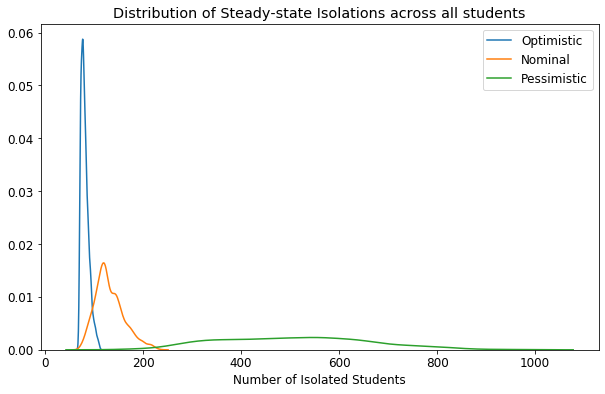

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

sns.distplot(isolation_student_optimistic, hist=False, rug=False, label='Optimistic')
sns.distplot(isolation_student_nominal, hist=False, rug=False, label='Nominal')
sns.distplot(isolation_student_pessimistic, hist=False, rug=False, label='Pessimistic')
plt.title('Distribution of Steady-state Isolations across all students')
plt.xlabel('Number of Isolated Students')
plt.show()

## Quarantines for UG High only

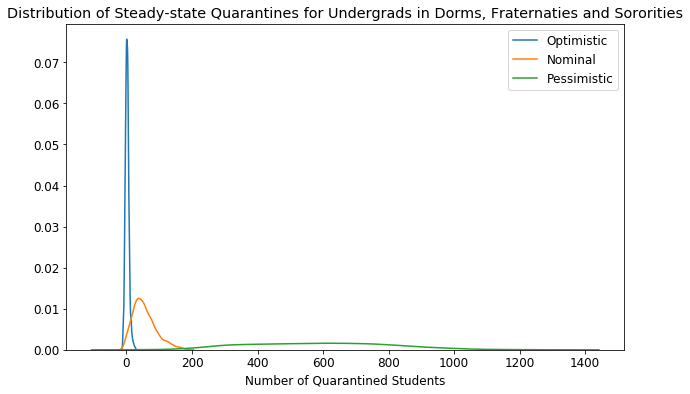

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

sns.distplot(quarantine_ug_high_optimistic, hist=False, rug=False, label='Optimistic')
sns.distplot(quarantine_ug_high_nominal, hist=False, rug=False, label='Nominal')
sns.distplot(quarantine_ug_high_pessimistic, hist=False, rug=False, label='Pessimistic')
plt.title('Distribution of Steady-state Quarantines for Undergrads in Dorms, Fraternaties and Sororities')
plt.xlabel('Number of Quarantined Students')
plt.show()

## Quarantines for all other students

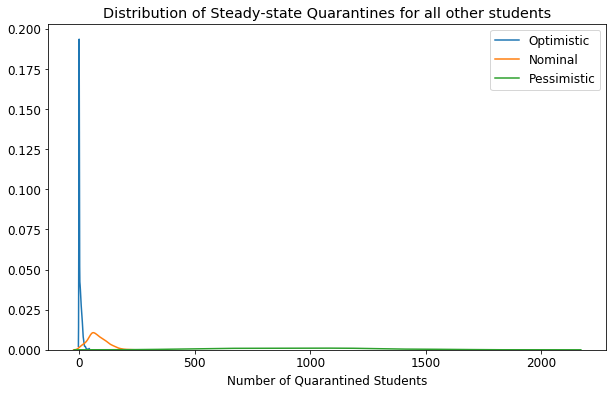

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

sns.distplot(quarantine_student_optimistic, hist=False, rug=False, label='Optimistic')
sns.distplot(quarantine_student_nominal, hist=False, rug=False, label='Nominal')
sns.distplot(quarantine_student_pessimistic, hist=False, rug=False, label='Pessimistic')
plt.title('Distribution of Steady-state Quarantines for all other students')
plt.xlabel('Number of Quarantined Students')
plt.show()

In [100]:
# np.mean(isolation_student_optimistic), np.mean(isolation_student_nominal), np.mean(isolation_student_pessimistic)
# np.mean(quarantine_ug_high_optimistic), np.mean(quarantine_ug_high_nominal), np.mean(quarantine_ug_high_pessimistic)
np.mean(quarantine_student_optimistic), np.mean(quarantine_student_nominal), np.mean(quarantine_student_pessimistic)

(4.456480952380949, 79.34091904761904, 949.6507142857145)

In [103]:
# np.quantile(isolation_student_optimistic, 0.9), np.quantile(isolation_student_nominal, 0.9), np.quantile(isolation_student_pessimistic, 0.9)
# np.quantile(quarantine_ug_high_optimistic, 0.9), np.quantile(quarantine_ug_high_nominal, 0.9), np.quantile(quarantine_ug_high_pessimistic, 0.9)
np.quantile(quarantine_student_optimistic, 0.9), np.quantile(quarantine_student_nominal, 0.9), np.quantile(quarantine_student_pessimistic, 0.9)

(13.029999999999994, 135.03, 1402.03)

In [75]:
# Pessimistic Total Infections
total_infections = list()
for sim in sim_results_pessimistic:
    scenario_total_infections = 0
    for i in range(7):
        scenario_total_infections += sim[i]['cumulative_mild'].tolist()[-1] + sim[i]['cumulative_severe'].tolist()[-1]
    total_infections.append(scenario_total_infections)
total_infections

[4445,
 4283,
 3761,
 4673,
 3723,
 4038,
 4511,
 3990,
 3862,
 4611,
 4977,
 4540,
 4742,
 3743,
 4773,
 4037,
 3561,
 3949,
 4198,
 4605,
 4226,
 4258,
 5013,
 3494,
 4138,
 3914,
 4358,
 3885,
 3766,
 3871,
 3919,
 4718,
 4370,
 4070,
 4798,
 4214,
 3939,
 3903,
 3814,
 3584,
 4306,
 3746,
 4251,
 4525,
 4502,
 3613,
 3836,
 4596,
 4409,
 3978]

In [94]:
np.min(total_infections), np.max(total_infections)
FP_isolation_optimistic

68.638